# Social Analysis and fatal police shooting in the US

In [1]:
#Data manipulation and visualization
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#for geopands
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

#customplot
plt.rcParams["figure.figsize"] = 10, 6
plt.style.use('ggplot')
sns.set_palette("Set2")


In [2]:
#Caricamento dati
Fatal_Shoothing = pd.read_csv('Data\\FatalPoliceShooting.csv', encoding="windows-1252", parse_dates=True)
Median_Income = pd.read_csv('Data\\MedianHouseholdIncome2015.csv', encoding="windows-1252")
Poverty_Rate = pd.read_csv('Data\\PercentagePeopleBelowPovertyLevel.csv', encoding="windows-1252")
Hs_Rate = pd.read_csv('Data\\PercentOver25CompletedHighSchool.csv', encoding="windows-1252")
Population_byCity = pd.read_csv('Data\\PopulationByCity.csv', encoding="windows-1252")
Race_byCity = pd.read_csv('Data\\ShareRaceByCity.csv', encoding="windows-1252")

# Social Analysis

Per prima cosa affrontiamo un'analisi di tipo strettamente sociale su alcune caratteristiche degli Stati Uniti basandoci sui dati a disposizione (reddito medio per famiglia, tasso di povertà, grado di istruzione e distribuzione etnica). 

Come prima cosa controlliamo la presenza di dati mancanti e se tutti i dati sono espressi nel formato giusto per poi passare all'analisi grafica.

In [3]:
#Tasso di povertà
Poverty_Rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29329 non-null  object
 1   City             29329 non-null  object
 2   poverty_rate     29329 non-null  object
dtypes: object(3)
memory usage: 687.5+ KB


Non ci sono valori nulli ma _poverty_rate_ non è formattato come un numero. Controlliamo che non contenga dei caratteri che non possono essere fomattati come numeri

In [4]:
Poverty_Rate.poverty_rate.value_counts()

0       1464
-        201
7.4      129
6.7      129
10.9     128
        ... 
73.5       1
92         1
73.8       1
55.9       1
83.6       1
Name: poverty_rate, Length: 771, dtype: int64

Ci sono 201 osservazioni registrate con il valore '-' che probabilmente è stato utilizzato per indicare un valore mancante, le sostituisco con 0 e converto la colonna in _float_

In [5]:
#Sostituisco il valore
Poverty_Rate.poverty_rate.replace(['-'], 0.0, inplace=True)
#converto la colonna
Poverty_Rate.poverty_rate = Poverty_Rate.poverty_rate.astype('float')

In [6]:
#Aggrego il tasso di povertà per stato per una visualizzazione più compatta 
Poverty_Rate_byState = Poverty_Rate.groupby('Geographic Area')['poverty_rate'].mean().sort_values(ascending=False)
Poverty_Rate_byState.head()

Geographic Area
MS    26.884254
AZ    25.268071
GA    23.663636
AR    22.963216
NM    22.507675
Name: poverty_rate, dtype: float64

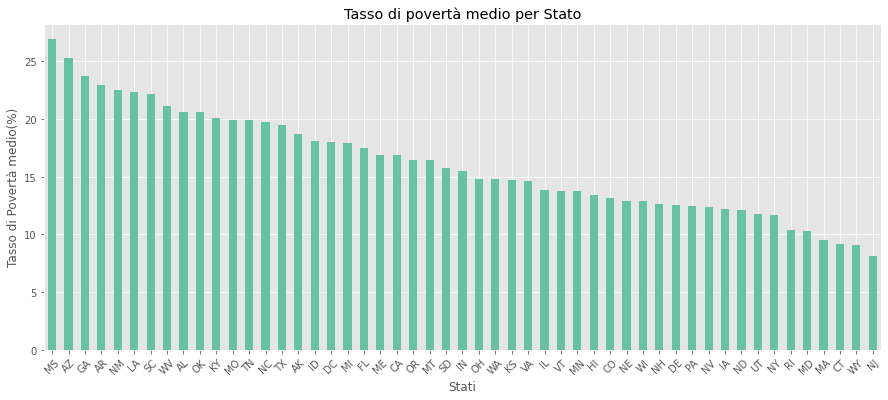

In [7]:
#Visualizzazione del tasso di povertà
plt.figure(figsize=(15,6))
Poverty_Rate_byState.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Tasso di povertà medio per Stato')
plt.xlabel('Stati')
plt.ylabel('Tasso di Povertà medio(%)');

Questo tipo di visualizzazione è molto semplice e non ha bisogno di commenti, praticamente possiamo vedere gli stati americani ordinati in base al tasso di povertà. Questo e altri grafici ritorneranno utili per considerazioni successive.

Vediamo come si distribuiscono i valori del tasso di povertà:

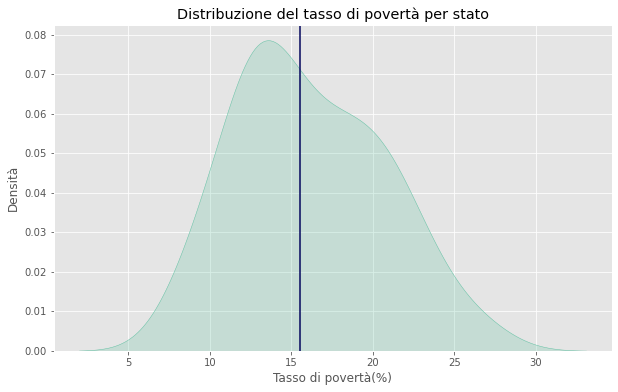

In [8]:
sns.kdeplot(Poverty_Rate_byState, shade=True)
#calcolo la mediana
poverty_median = np.median(Poverty_Rate_byState)
#Inserisco la mediana nel grafico
plt.axvline(poverty_median, c='#00035b')

plt.title('Distribuzione del tasso di povertà per stato')
plt.xlabel('Tasso di povertà(%)')
plt.ylabel('Densità');

Da questo grafico si evince che il valore più comune del tasso di povertà negli Stati Uniti è compreso fra 12% e 15%, ma molti valori ricando anche nella fascia 15-20%, infatti la mediana si trova di poco oltre il 15%. In generale sembrerebbe che il tasso di povertà non sia molto elevato negli Stati Uniti, tuttavia bisogna considerare che questa misura non è sempre precisa ed è spesso soggetta a bias a seconda del metodo di raccolta utilizzato (Fonte: https://blogs.worldbank.org/developmenttalk/why-measuring-poverty-impacts-more-difficult-simply-using-score-cards).

Passiamo all'analisi del Reddito medio per famiglia.

In [9]:
#Reddito per famiglia 
Median_Income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29322 entries, 0 to 29321
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29322 non-null  object
 1   City             29322 non-null  object
 2   Median Income    29271 non-null  object
dtypes: object(3)
memory usage: 687.4+ KB


Anche qui abbiamo lo stesso problema dell'altro dataset; in questo caso utilizzo una sintassi diversa dato che il nome della colonna ha uno spazio fra i caratteri al fine di non incorrere in un _SyntaxError_.

In [10]:
Median_Income['Median Income'].value_counts()

(X)      1113
-         740
38750     136
41250     125
43750     115
         ... 
45398       1
45945       1
26411       1
24228       1
77114       1
Name: Median Income, Length: 14592, dtype: int64

In [11]:
#Sostituisco i valori '-' e '(X)' con 0 
Median_Income['Median Income'].replace(['-','(X)','2,500-', '250,000+'], 0.0, inplace=True)
#Converto la colonna
Median_Income['Median Income'] = Median_Income['Median Income'].astype('float')

Questo dataset conteneva anche i valori _2500-_ e _250000+_ per indicare fasce di reddito molto basse e molto alte, ho dovuto comunque rimuoverli altrimenti non avrei potuto convertire la colonna in float ed effettuare operazioni di aggregazione. La perdita più grave derivante da questa operazione è per i redditi particolarmente elevati (cioè 250000+) visto che abbiamo comunque una misura della povertà con il dataset dedicato; ai fini dell'analisi ho ritenuto più importante il valore medio aggregato per stato.  

In [12]:
Median_Income_State = Median_Income.groupby('Geographic Area')['Median Income'].mean().sort_values(ascending=False)

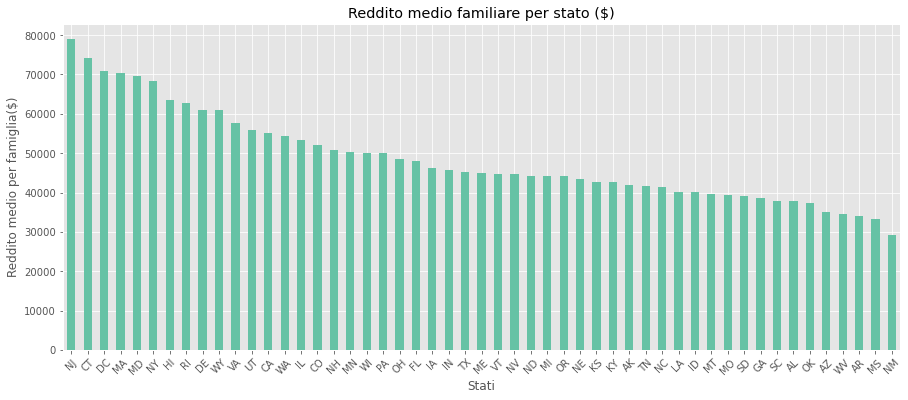

In [13]:
plt.figure(figsize=(15,6))
Median_Income_State.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Reddito medio familiare per stato ($)')
plt.xlabel('Stati')
plt.ylabel('Reddito medio per famiglia($)');

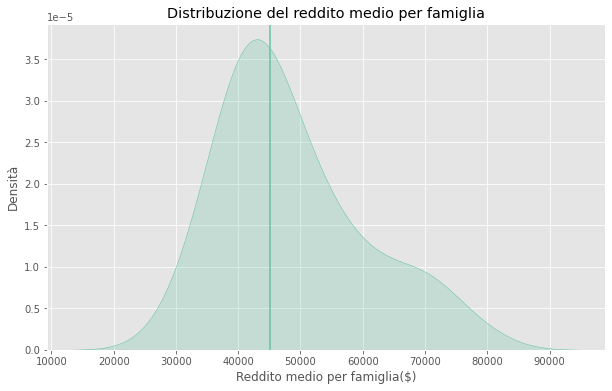

In [14]:
sns.kdeplot(Median_Income_State, shade=True)
#calcolo la mediana
income_median = np.median(Median_Income_State)
#visualizzo la mediana
plt.axvline(income_median)
plt.title('Distribuzione del reddito medio per famiglia')
plt.xlabel('Reddito medio per famiglia($)')
plt.ylabel('Densità');

La fascia di reddito più comune è quella compresa fra 40.000 e 50.000 dollari, all'interno della quale ricade anche la mediana della distribuzione.
Dai grafici è possibile notare che il New Jersey, è sia lo stato con il tasso di povertà più basso, che lo stato con il più alto reddito medio per famiglia; infatti è logico pensare che queste due varibili siano negativamente correlate fra di loro, controlliamo graficamente.

In [15]:
#Unisco i dati Reddito medio e tasso di povertà
IncomeVsPoverty = pd.concat([Median_Income_State, Poverty_Rate_byState], axis=1)

In [16]:
IncomeVsPoverty.head()

,Median Income,poverty_rate
Geographic Area,,
NJ,78957.932110,8.160917
CT,74098.608392,9.137500
DC,70848.000000,18.000000
MA,70307.256098,9.546341
MD,69529.565637,10.272394


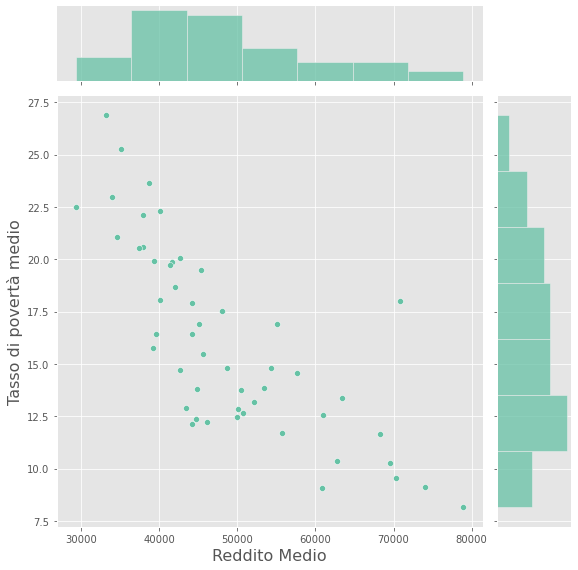

In [17]:
ip = sns.jointplot(x='Median Income', y='poverty_rate', data=IncomeVsPoverty, height=8)
ip.set_axis_labels('Reddito Medio', 'Tasso di povertà medio', fontsize=16);

Come ci si aspettava Reddito medio e Tasso di povertà sono legati da una relazione negativa. 
Passiamo ora ad analizzare la quota di diplomati per stato.

In [18]:
#Rimuovo valori non numerici
Hs_Rate.percent_completed_hs.replace(['-','(X)'], 0.0, inplace=True)
#Converto la colonna
Hs_Rate.percent_completed_hs = Hs_Rate.percent_completed_hs.astype('float')
#Aggrego e ordino
Hs_Rate_State = Hs_Rate.groupby('Geographic Area')["percent_completed_hs"].mean().sort_values(ascending=False)

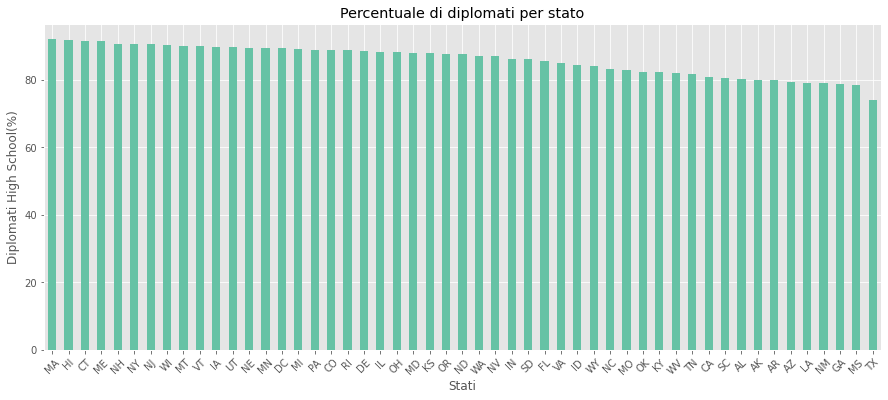

In [19]:
plt.figure(figsize=(15,6))
Hs_Rate_State.plot(kind='bar')
plt.xticks(rotation=45)
plt.title("Percentuale di diplomati per stato")
plt.xlabel('Stati')
plt.ylabel('Diplomati High School(%)');

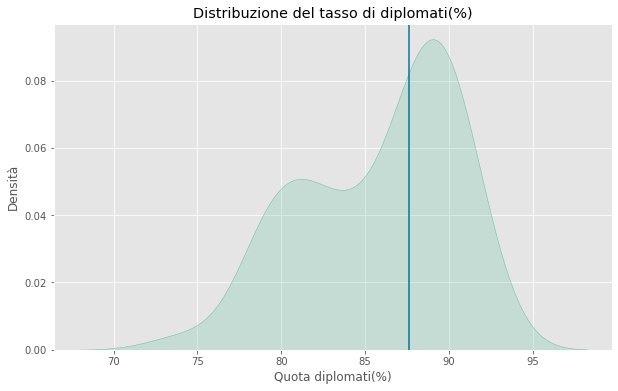

In [20]:
sns.kdeplot(Hs_Rate_State, shade=True)
#calcolo la mediana
hs_median = np.median(Hs_Rate_State)
#visualizzo la mediana
plt.axvline(hs_median, c='#047495')
plt.title('Distribuzione del tasso di diplomati(%)')
plt.xlabel('Quota diplomati(%)')
plt.ylabel('Densità');

Si noti che, per quanto riguarda la quota di abitanti diplomati per stato c'è molta meno differenza fra gli stati rispetto alle altre due variabili precedentemente analizzate.Possiamo anche notare un distribuzione di densità bimodale  con una median spostata leggermente a destra fra 85% e 90%.

Proviamo a vedere se un'istruzione superiore equivale ad un reddito medio per famiglia più elevato.

In [21]:
#Unisco i dati
EducationVsIncome = pd.concat([Median_Income_State, Hs_Rate_State], axis=1)

In [22]:
EducationVsIncome.head()

,Median Income,percent_completed_hs
Geographic Area,,
NJ,78957.932110,90.520550
CT,74098.608392,91.591667
DC,70848.000000,89.300000
MA,70307.256098,92.028455
MD,69529.565637,88.081081


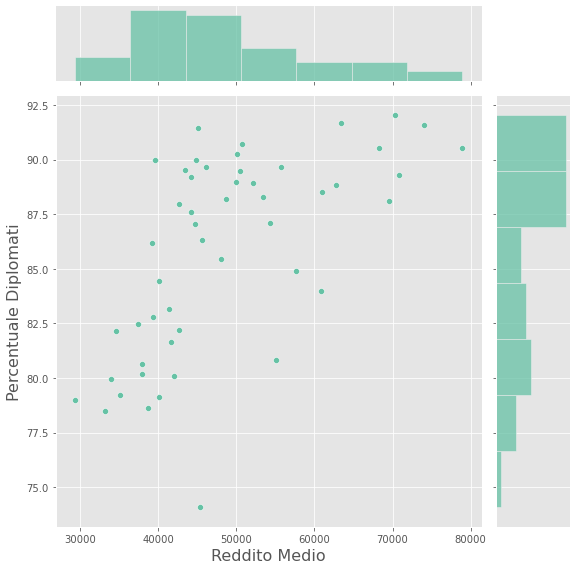

In [23]:
ei = sns.jointplot(x='Median Income', y='percent_completed_hs', data=EducationVsIncome,  height=8)
ei.set_axis_labels('Reddito Medio', 'Percentuale Diplomati', fontsize=16);

In questo caso abbiamo una relazione positiva anche se più debole perché i punti sono più dispersi. Si noti anche la presenza di un valore _outlier_ che salta subito agli occhi ed è subito riconoscibile. Si tratta del Texas, che è uno dei pochi stati ad avere un tasso di diplomati inferiore all' 80%, nonostante rientri comunque nella fascia di reddito più comune fra 40.000 e 50.000.
Passiamo adesso all'analisi della distribuzione delle diverse etnie.

In [24]:
#Rimuovo i valori non numerici
Race_byCity.replace(['-'],0.0,inplace=True)
Race_byCity.replace(['(X)'],0.0,inplace=True)

In [25]:
#Converto le colonne
Race_byCity["share_white"] = Race_byCity['share_white'].astype('float')
Race_byCity["share_black"] = Race_byCity['share_black'].astype('float')
Race_byCity["share_native_american"] = Race_byCity['share_native_american'].astype('float')
Race_byCity["share_asian"] = Race_byCity['share_asian'].astype('float')
Race_byCity["share_hispanic"] = Race_byCity['share_hispanic'].astype('float')

In [26]:
Race_byCity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geographic area        29268 non-null  object 
 1   City                   29268 non-null  object 
 2   share_white            29268 non-null  float64
 3   share_black            29268 non-null  float64
 4   share_native_american  29268 non-null  float64
 5   share_asian            29268 non-null  float64
 6   share_hispanic         29268 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.6+ MB


In [27]:
#Agrego i dati
Race_by_State = Race_byCity[[x for x in Race_byCity.columns if 'share' in x] + ['Geographic area']].groupby('Geographic area').mean()

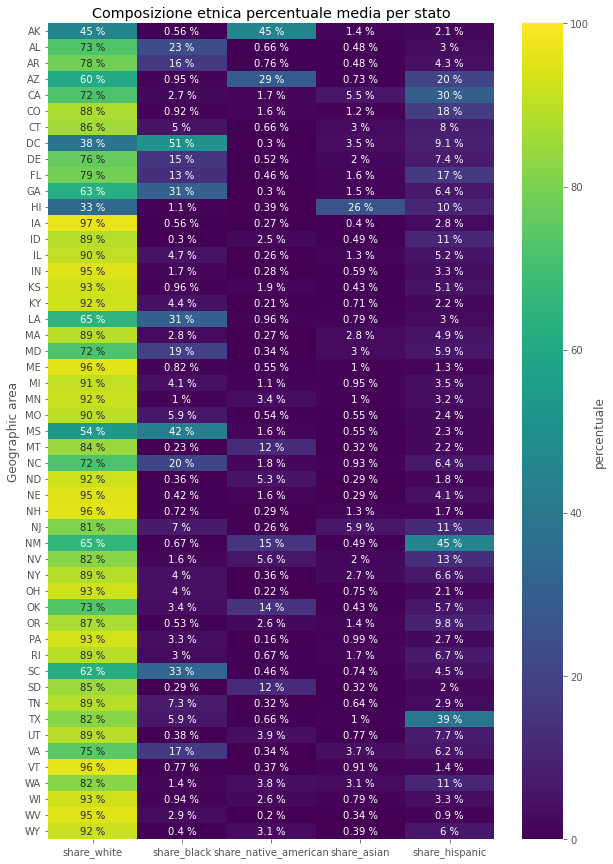

In [28]:
plt.figure(figsize=(10,15))
et = sns.heatmap(Race_by_State, vmin=0, vmax=100, cmap='viridis', annot=True,cbar_kws={'label': 'percentuale'})
for t in et.texts: t.set_text(t.get_text() + " %")
plt.title('Composizione etnica percentuale media per stato');

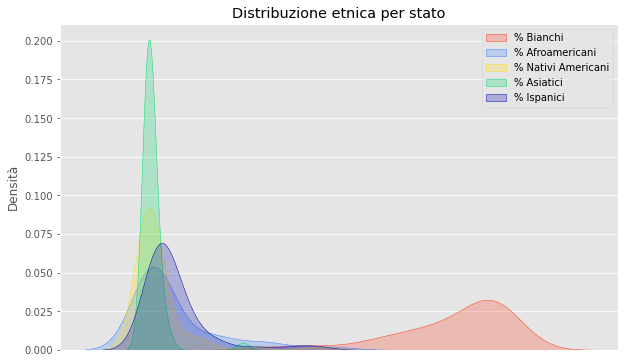

In [29]:
fig, ax = plt.subplots(1,1)
ax.xaxis.set_ticks([])

sns.kdeplot(Race_by_State.share_white, ax=ax, shade=True, color='#fd411e')
sns.kdeplot(Race_by_State.share_black, ax=ax, shade=True, color='#3e82fc')
sns.kdeplot(Race_by_State.share_native_american, ax=ax, shade=True, color='#ffdf22')
sns.kdeplot(Race_by_State.share_asian, shade=True, color='#0cdc73')
sns.kdeplot(Race_by_State.share_hispanic, ax=ax, shade=True, color='#030aa7')


ax.set_title("Distribuzione etnica per stato")
ax.set_xlabel(' ')
ax.set_ylabel('Densità') 
plt.legend(['% Bianchi', '% Afroamericani','% Nativi Americani', '% Asiatici', '% Ispanici']);

È possibile trarre alcune conclusioni da questi due grafici.Dal primo si evince che la maggior parte della popolazione statunitense è composta da bianchi, mentre il secondo gruppo più rappresentato sono gli afroamericani. Soltanto in alcuni stati il secondo gruppo etnico maggiormente rappresentato sono gli ispanici. Gli stati che registrano una maggiore presenza di nativi americani, oltre l'Alaska (AK), sono quelli dove sono presenti riserve federali (Fonte:  https://en.wikipedia.org/wiki/List_of_Indian_reservations_in_the_United_States) e ciò emerge anche dal grafico della distrubzione di densità. Alcuni gruppi etnici sono distribuiti più equamente, mentre i nativi americani e gli asiatici sono altamente concentrati in pochi stati (per gli asiatici sono le Hawaii). 

Proseguiamo analizzando il dataset relativo alle vittime della polizia

# Police Shootings Analysis

In questo DataSet abbiamo a disposizione molte variabili interessanti per analizzare il fenomeno delle vittime della polizia statunitense dal 2016 al 2021

In [30]:
Fatal_Shoothing.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [31]:
Fatal_Shoothing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6329 entries, 0 to 6328
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       6329 non-null   int64  
 1   name                     6095 non-null   object 
 2   date                     6329 non-null   object 
 3   manner_of_death          6329 non-null   object 
 4   armed                    6121 non-null   object 
 5   age                      6049 non-null   float64
 6   gender                   6328 non-null   object 
 7   race                     5708 non-null   object 
 8   city                     6329 non-null   object 
 9   state                    6329 non-null   object 
 10  signs_of_mental_illness  6329 non-null   bool   
 11  threat_level             6329 non-null   object 
 12  flee                     5925 non-null   object 
 13  body_camera              6329 non-null   bool   
 14  longitude               

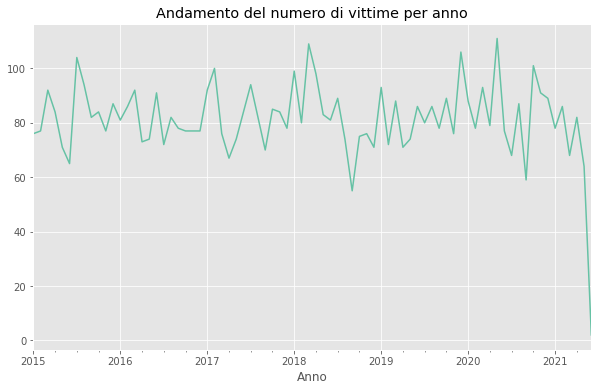

In [32]:
Fatal_Shoothing['date'] = Fatal_Shoothing['date'].apply(lambda x: pd.to_datetime(x))
Fatal_Shoothing['date'].groupby(Fatal_Shoothing.date.dt.to_period('M')).count().plot(kind='line')
plt.title('Andamento del numero di vittime per anno')
plt.xlabel('Anno');

Considerando un periodo mensile nel corso dei 6 anni (visto che per il 2021 non abbiamo i dati completi), possiamo vedere che a metà del 2015, all'inizio del 2018 e nel primo quarto del 2020, si sono raggiunti picchi di oltre 100 morti al mese. Su base mensile non possiamo affermare che il fenomeno abbia una certa stagionalità.

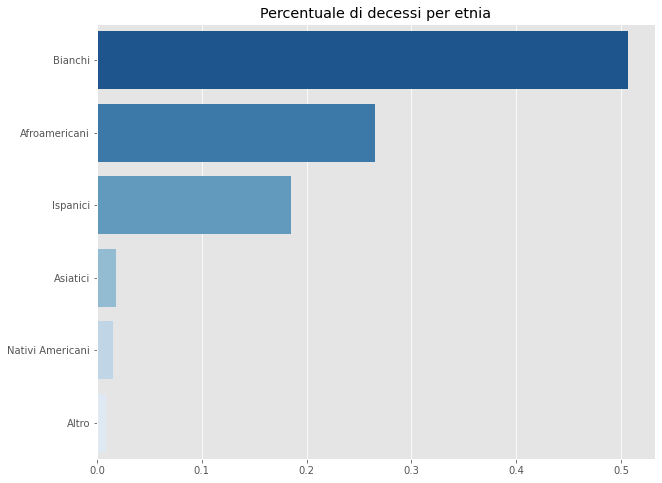

In [33]:
#Conto i episodi in base all'etnia
Shoot_Race = Fatal_Shoothing.race.value_counts(normalize=True)
#Aggiungo gli indici relativi all'etnia
Shoot_Race.index = ['Bianchi', 'Afroamericani', 'Ispanici', 'Asiatici', 'Nativi Americani', 'Altro']

#Visualizzazione
fig, ax = plt.subplots(1,1 , figsize=(10,8))
sns.barplot(y=Shoot_Race.index, x=Shoot_Race.values, palette='Blues_r')
ax.set_title('Percentuale di decessi per etnia')
plt.show()

Da questo grafico si evince che circa la metà delle vittime è di etnia bianca. Un risultato del genere non è sorprendente visto che la maggior parte della popolazione statunitense è composta da persone di etnia bianca (come visto nel grafico _'Composizione etnica per stato'_). Per questo motivo è importante riproporre la stessa visualizzazione ma tenendo conto della quota etnica in rapporto alla popolazione totale.

Per fare ciò creo una Pandas Series con i dati contenuti in: https://data.census.gov/cedsci/table?q=Hispanic%20or%20Latino&tid=ACSDP1Y2019.DP05&hidePreview=false . Potrei aggregare nuovamente _Race_byState_ per ottenre la quota totale delle etnie sull'intera popolazione degli Stati Uniti, tuttavia preferisco utilizzare un valore più accurato e non manipolare ulteriormente i dati di quela dataset.

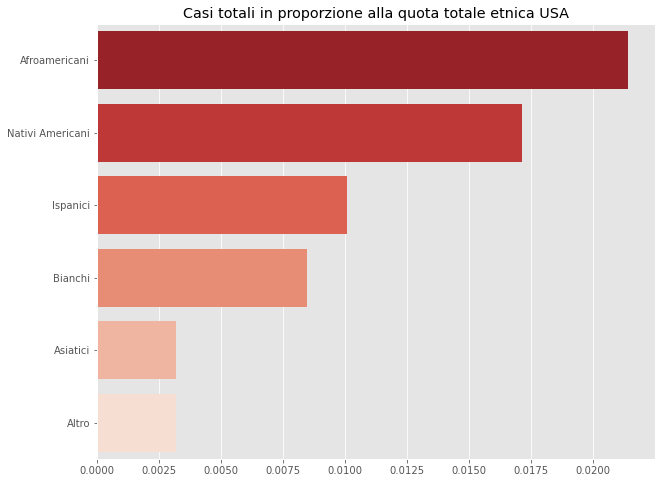

In [34]:
#Creo la serie
Share_Race_US2019 = pd.Series([60.0, 12.4, 0.9, 5.7, 18.4, 2.6], index=['Bianchi', 'Afroamericani', 'Nativi Americani', 'Asiatici', 'Ispanici','Altro'])

#Calcolo la quota di vittime in base alla quota etnica sull'intera popolazione americana 
TotalShare_Shooting = Shoot_Race / Share_Race_US2019
#Ordino i valori
TotalShare_Shooting = TotalShare_Shooting.sort_values(ascending=False)

#Visualizzazione
fig, ax = plt.subplots(1,1 , figsize=(10,8))
sns.barplot(y=TotalShare_Shooting.index, x=TotalShare_Shooting.values, palette='Reds_r')
ax.set_title('Casi totali in proporzione alla quota totale etnica USA')
plt.show()


Quindi in proporzione, le vittime della polizia sono maggiormente afroamericani (e ciò potrebbe indicare la presenza di un pregiudizio). È interessante notare anche che, in proporzione, la seconda etnia è quella dei nativi americani nonostante rappresenti soltanto lo 0.9% della popolazione totale. 

Vediamo adesso come si dristribuisce l'età delle vittime.

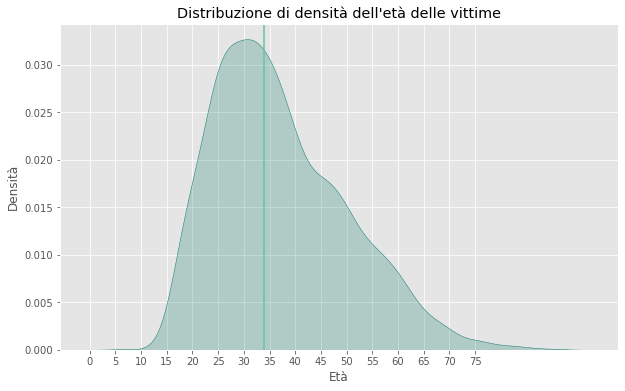

In [35]:
#Visualizzazione età
sns.kdeplot(Fatal_Shoothing.age, color='#137e6d', shade=True)
plt.xticks(np.arange(0, 80, 5.0))
#calcolo la mediana
age_med = np.median(Fatal_Shoothing.dropna().age)
plt.axvline(age_med)
plt.title("Distribuzione di densità dell'età delle vittime")
plt.xlabel('Età')
plt.ylabel('Densità');

La maggior parte delle vittime rientra nella fascia fra i 20 e i 40 anni.Con la mediana della distribuzione collocata a 35. Sebbene siano molto più rari sono presenti anche dei casi con un'età piuttosto elevata compresa fra i 60 e gli 80 anni. Vediamo come questa distribuzione cambia in base all'etnia.

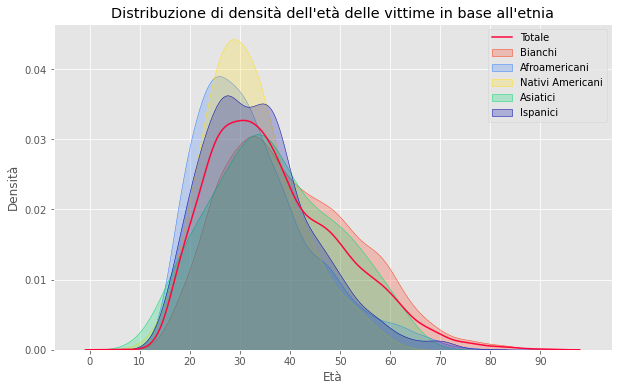

In [36]:
fig, ax = plt.subplots(1,1)
ax.xaxis.set_ticks(np.arange(0, 100, 10))

sns.kdeplot(Fatal_Shoothing[Fatal_Shoothing.race == 'W'].age, ax=ax, shade=True, color='#fd411e')
sns.kdeplot(Fatal_Shoothing[Fatal_Shoothing.race == 'B'].age, ax=ax, shade=True, color='#3e82fc')
sns.kdeplot(Fatal_Shoothing[Fatal_Shoothing.race == 'N'].age, ax=ax, shade=True, color='#ffdf22')
sns.kdeplot(Fatal_Shoothing[Fatal_Shoothing.race == 'A'].age, ax=ax, shade=True, color='#0cdc73')
sns.kdeplot(Fatal_Shoothing[Fatal_Shoothing.race == 'H'].age, ax=ax, shade=True, color='#030aa7')
sns.kdeplot(Fatal_Shoothing.age, color='#ff073a')

ax.set_title("Distribuzione di densità dell'età delle vittime in base all'etnia")
ax.set_xlabel('Età')
ax.set_ylabel('Densità') 
plt.legend(['Totale','Bianchi', 'Afroamericani','Nativi Americani', 'Asiatici', 'Ispanici',]);

Si noti che la funzione di densità degli afroamericani è più a sinistra sia rispetto alle altre etnie che rispetto al valore totale. Questo vuol dire che le vittime di etnia afroamericana di concentrano in una fascia di età mediamente più bassa.

Analizziamo adesso altre caratteristiche delle vittime e l'uso o meno delle body cam da parte della polizia. 

In [37]:
#Creo le variabili da visualizzare

#Segni di squilibrio mentale
v_1 = Fatal_Shoothing['signs_of_mental_illness'].value_counts(normalize=True)

#livello di minaccia
v_2 = Fatal_Shoothing['threat_level'].value_counts(normalize=True)

#presenza di body camera
v_3 = Fatal_Shoothing['body_camera'].value_counts(normalize=True)

#causa del decesso
v_4 = Fatal_Shoothing['manner_of_death'].value_counts(normalize=True)

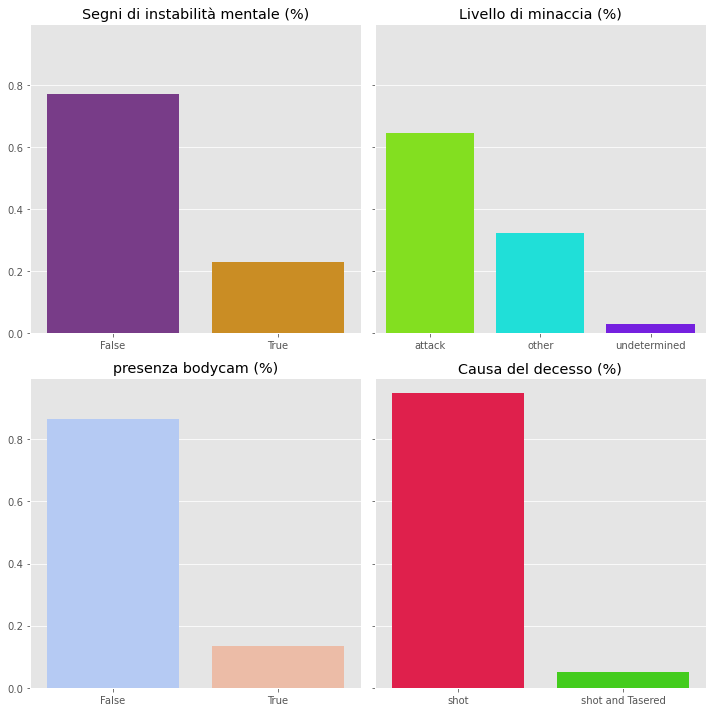

In [38]:
#Visualizzazione
fig, ax = plt.subplots(2,2,figsize=(10,10), sharey=True)
sns.barplot(x=v_1.index, y=v_1.values, palette='CMRmap', ax=ax[0,0])
ax[0,0].set_title('Segni di instabilità mentale (%)')
sns.barplot(x=v_2.index, y=v_2.values, palette='hsv', ax=ax[0,1])
ax[0,1].set_title('Livello di minaccia (%)')
sns.barplot(x=v_3.index, y=v_3.values, palette='coolwarm', ax=ax[1,0])
ax[1,0].set_title('presenza bodycam (%)')
sns.barplot(x=v_4.index, y=v_4.values, palette='prism_r', ax=ax[1,1])
ax[1,1].set_title('Causa del decesso (%)')
plt.tight_layout();

Si possono trarre diverse conclusioni da questi grafici:

* Soltanto in poco più del 20% dei casi le vittime mostravo segni di instabilità mentale
* Solo nel 10% dei casi la polizia indossava la body camera
* Nella maggior parte dei casi è stato segnalato un livello di minaccia elevato
* La variabile _'Causa del decesso'_ non è molto interessante perché quasi tutti i casi sono 'shot'(arma da fuoco) 

Dal momento che alla maggior parte dei casi è stato assegnato un livello di minaccia elevato, ci si aspetta che la maggior parte delle vittime fosse armata.

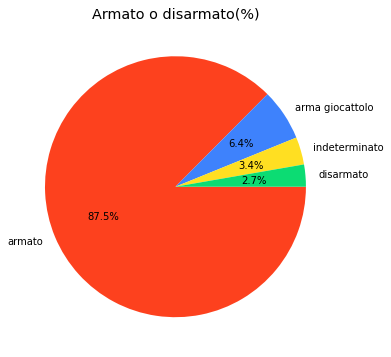

In [39]:
#Creo una funzione per raggruppare i casi della colonna armed 
def armed_unarmed(x):
    if x != 'unarmed' and x != 'toy weapon' and x != 'undetermined':
        return 'armato'
    if x == 'toy weapon':
        return 'arma giocattolo'
    if x == 'undetermined':
        return 'indeterminato'
    else:
        return 'disarmato'
    
#Creazione dati e visualizzazione
armato_disarmato = Fatal_Shoothing.armed.apply(armed_unarmed).value_counts(normalize=True)
labels = ['armato', 'arma giocattolo','indeterminato', 'disarmato']
plt.pie(armato_disarmato, labels=labels, autopct='%1.1f%%', colors=['#fd411e','#3e82fc', '#ffdf22','#0cdc73'],counterclock=False)
plt.title('Armato o disarmato(%)')
plt.show()

Come ci aspettavamo, la maggior parte delle vittime era armata. 

Nonostante le statistiche sul tasso di criminalità soffrano di un bias di campionamento (perché vengono conteggiati soltanto i crimini che sono stati denunciati), di solito il tasso di criminalità è più elevato fra gli uomini rispetto alle donne (fonte: https://www.statista.com/statistics/424145/prevalence-rate-of-violent-crime-in-the-us-by-gender/). Vediamo se questa statistica viene rispettata nel nostro data set.

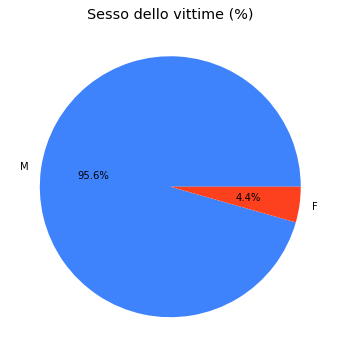

In [40]:
plt.pie(Fatal_Shoothing.gender.value_counts(normalize=True), labels=['M', 'F'], autopct='%1.1f%%', colors=['#3e82fc','#fd411e'])
plt.title('Sesso dello vittime (%)')
plt.show()

Anche nel nostro caso la maggior parte delle vittime sono uomini

# Combined Analysis

Adesso uniamo i dati presenti nelle due analisi per visualizzare altre relazioni interessanti

In [41]:
#Creo un dataframe con le vittime, le città e lo stato
cases = Fatal_Shoothing.groupby(['state','city']).count()['id'].reset_index()
cases.columns = ['state','city','cases']
#Unisco i dataframe della social analysis in uno solo
Social_var = pd.merge(Poverty_Rate, Hs_Rate)
Social_var = pd.merge(Social_var, Median_Income)
Social_var.columns = ['state','city','poverty_rate','percent_completed_hs','median_income']
# Modifico il nome delle città di Social_var perché non è uguale a quello di cases, rimuovo la seconda parte e tengo solo la prima parte del nome
Social_var['city'] = Social_var['city'].apply(lambda x: x.rsplit(' ',1)[0])
#controllo se ci sono indici duplicati e li rimuovo
duplicate_index = Social_var[['state','city']][Social_var[['state','city']].duplicated()].index
Social_var = Social_var.drop(duplicate_index)
#Unisco tutto in un unico dataframe
Social_var = pd.merge(cases, Social_var, on=['state','city'], how='left')


In [42]:
Social_var.head()

,state,city,cases,poverty_rate,percent_completed_hs,median_income
0,AK,Anchor Point,1,10.1,93.8,51591.0
1,AK,Anchorage,11,8.2,93.0,78326.0
2,AK,Barrow,1,11.7,84.6,76902.0
3,AK,Big Lake,1,9.6,90.4,70988.0
4,AK,Copper Center,1,18.8,84.8,39063.0


Infine per completare il dataframe aggiungo i dati relativi alla popolazione inclusi in '_PopulationByCity_'.

In [43]:
total = pd.merge(Social_var, Population_byCity, on=['state','city'], how='left').dropna()
#creo una colonna che indica la percentuale di casi rispetto alla popolazione della città
total['cases_on_population'] = (total['cases']/total['population'])*100
total.head()

,state,city,cases,poverty_rate,percent_completed_hs,median_income,population,lat,lng,cases_on_population
0,AK,Anchor Point,1,10.1,93.8,51591.0,2057.0,59.7703,-151.7052,0.048614
1,AK,Anchorage,11,8.2,93.0,78326.0,253421.0,61.1508,-149.1091,0.004341
3,AK,Big Lake,1,9.6,90.4,70988.0,3136.0,61.5260,-149.9721,0.031888
4,AK,Copper Center,1,18.8,84.8,39063.0,397.0,61.9845,-145.3544,0.251889
6,AK,Fairbanks,10,13.1,91.2,55229.0,64732.0,64.8353,-147.6534,0.015448


Adesso vediamo come i casi variano a seconda delle variabili sociali analizzate in precedenza

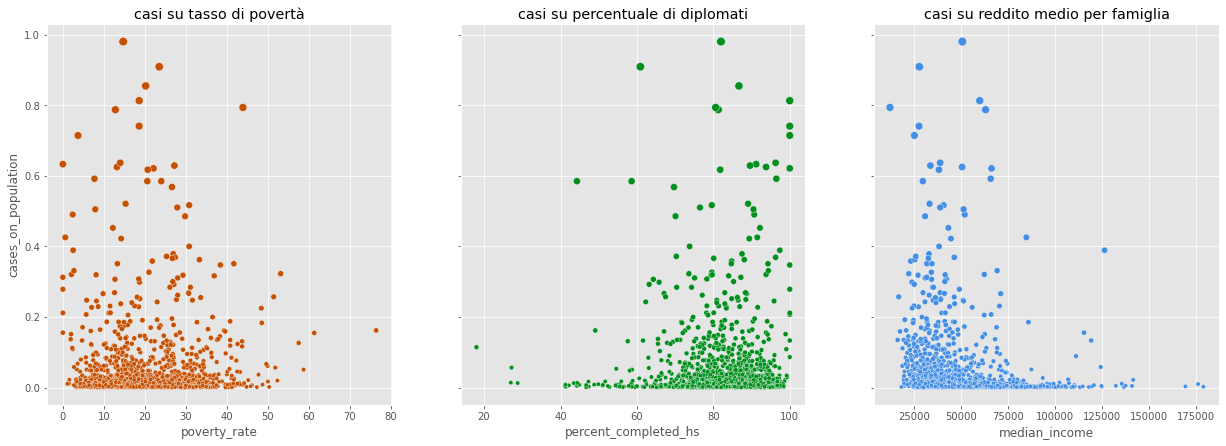

In [44]:
fig, ax = plt.subplots(1,3, figsize=(21,7), sharey=True)
#Includo nel grafico soltanto le città con popolazione > 100 altrimenti la visualizzazione risulterebbe troppo densa 
sns.scatterplot(y='cases_on_population', x='poverty_rate', data=total[(total.population > 100)], ax=ax[0],size='cases_on_population', color='#c65102', legend=False)
sns.scatterplot(y='cases_on_population', x='percent_completed_hs', data=total[(total.population > 100)], ax=ax[1],size='cases_on_population', color='#028f1e', legend=False)
#Ci sono valori di reddito medio pari a 0, quindi li escludo per una rappresentazione migliore
sns.scatterplot(y='cases_on_population', x='median_income', data=total[(total.population > 100) & (total.median_income > 0)], ax=ax[2],size='cases_on_population', color='#448ee4', legend=False)

ax[0].set_title('casi su tasso di povertà')
ax[1].set_title('casi su percentuale di diplomati')
ax[2].set_title('casi su reddito medio per famiglia')
plt.show()

A quanto pare le città con un tasso di povertà più elevato non registrano casi maggiori. Come visto in precedenza la percentuale di diplomati negli Stati Uniti è piuttosto omogenea, intorno all'80%, e infatti la maggior parte dei casi si concentrano in questa fascia. Infine, si può notare che la maggior parte dei casi si verifica in una fascia di reddito compresa fra 25.000 e $ 50.000 dollari.

Per concludere l'analisi visualizziamo alcune mappe.

In [45]:
#Creo un DataFrame con la somma di vittime per stato
sum_state = Fatal_Shoothing.groupby(['state']).apply(lambda x:x['manner_of_death'].count()).reset_index(name='Counts')


In [46]:
#Modifico il nome degli stati perché nello shape file sono scritti per esteso

states = {
        'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
        'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii',
        'IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts',
        'MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi',
        'MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
        'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico',
        'RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
        'VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
}

sum_state.replace(to_replace=states, inplace=True)
sum_state.set_index('state')
sum_state.head()

,state,Counts
0,Alaska,44
1,Alabama,121
2,Arkansas,90
3,Arizona,296
4,California,939


Per la realizzazione di questo grafico utilizzo uno shape file di Kaggle.
Fonte:https://www.kaggle.com/ambarish/us-states-cartographic-boundary-shapefiles

In [47]:
usa = gpd.read_file('Data\\cb_2016_us_state_500k.shp')
data_map = usa.set_index('NAME').join(sum_state.set_index('state'))
var='Counts'

#Imposto valore minimo e massimo
vmin, vmax = np.min(data_map.loc[:,['Counts']]), np.max(data_map.loc[:,['Counts']])

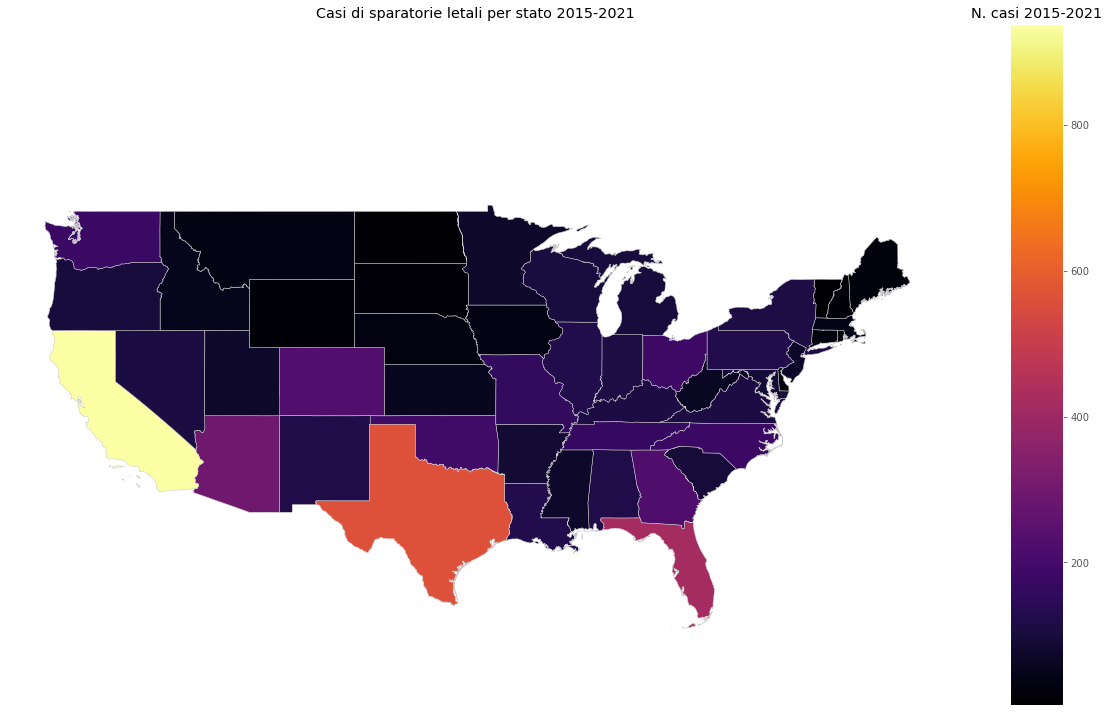

In [48]:
#Visualizzazione

fig, ax = plt.subplots(1,1, figsize=(20,20))

#imposto limite assi, non ho incluso l'Alaska perché la visualizzazione è fuori scala
ax.set_xlim(-127,-65)
ax.set_ylim(20,60)

#Impostazioni per la color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1,)

data_map.plot(column=var, ax=ax, legend=True,cax=cax, cmap='inferno', edgecolor='0.8')

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("white")
ax.set_title('Casi di sparatorie letali per stato 2015-2021')
cax.set_title('N. casi 2015-2021')

plt.show()


Da questa cartina si può vedere che alcuni stati del sud hanno registrato un maggior numero di casi (California, Arizona, Texas e Florida), anche lo stato di Whashington e il Colorado mostrano un numero di casi piuttosto elevato  

In [49]:
#Rappresentazione con plotly Graph Objects
fig = go.Figure(data=go.Scattergeo(
        lon = Fatal_Shoothing['longitude'], #Coordinate geografiche dal df
        lat = Fatal_Shoothing['latitude'],  #Coordinate geografiche dal df
        text = Fatal_Shoothing['city'] + ', ' + Fatal_Shoothing['state'] + ': ' + Social_var['cases'].astype(str) ,
        mode = 'markers', #Inserisco il testo da visualizzare al passaggio
        marker = dict(
            size = Social_var['cases'].apply(lambda x: 4 if x < 5 else x), #Per i casi totali uso il valore di Social_var
            opacity = 0.8,
            symbol = 'circle',
            colorscale = 'bluered_r',
            reversescale = True,
            cmin = 1,
            color = Social_var['cases'],
            cmax = Social_var['cases'].max(),
            colorbar_title="N. Casi 2015-2021"
        )))

fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        title = 'Casi di sparatorie letali per città 2015 - 2021',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = False,
            landcolor = "blue",
            subunitcolor = "blue",
            countrycolor = "blue",
            subunitwidth = 0.5
        )
    )
fig.update_layout(title_x=0.5)
fig.show('notebook_connected')

Da questo grafico possiamo vedere i casi per singole città. Ad esempio, se ci concentriamo sulla California, possiamo notare la maggior parte dei casi si sono registrai nell'area metropolitana di Los Angeles; A Dublin invece in North Carolina si sono registrati circa 90 decessi. Nello stato di Whashington abbiamo due città con valori abbastanza elevati: Tacoma e Spokane; In particolare, la città di Tacoma è stata teatro di un recente episodio (Maggio 2021), con l'uccisione di Manuel Ellis, che ha portato all'accusa di 3 agenti. (Fonte:https://www.theguardian.com/us-news/2021/may/27/manuel-ellis-tacoma-three-officers-charged-death). La città di Spokane invece ha il terzo dipartimento di polizia più letale d'America (Fonte: https://www.scarspokane.org/police-brutality) 

# Conclusioni

* Dal 2015 non c'è stata alcuna riduzione nel numero delle vittime della polizia. Anzi il 2020 ha registrato un aumento dei casi nonostante la presenza delle restrizioni dovute alla pandemia.
* Nonostante gli afroamericani rappresentino soltanto il 12.4% della popolazione totale degli Stati Uniti sono la minoranza più colpita. Grazie al movimento Black Lives Matter la consapevolezza di questo fenomeno sta crescendo nella popolazione non solo statunitense ma di tutto il mondo.
* Le vittime afroamericane sono anche più giovani rispetto alle altre etnie.
* La maggior parte delle vittime sono uomini.
* Si sono registrati molti meno omicidi quando la polizia indossava le bodycam. Ciò suggerisce che adottare questi strumenti potrebbe condurre ad una riduzione degli omicidi da parte della polizia e al tempo stesso difendere gli agenti in caso di ricorso legittimo alla forza.
* L'87.5% delle vittime era armato quando è stato ucciso dalla polizia.
* Le città con un tasso di povertà più elevato non mostrano una maggiore incidenza di vittime; così come un reddito medio più basso non corrisponde ad un maggior numero di vittime.
* Gli stati del sud sono quelli maggiormente interessati dal fenomeno sebbene episodi gravi si registrino in tutti gli Stati Uniti.